# Разведочный анализ данных

**Цели и задачи:**<br>
- Провести EDA данных;
- Изучить особенности, выявить закономерности в данных;
- Определить объем пропущенных данных;
- Сделать выводы и рекомендации для дальнейшей обработки данных.

## Загрузка необходимых бибилиотек

In [1]:
import pandas as pd
import numpy as np
import datetime
import glob

from scipy import stats as sts
import statistics as stat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

## 1. Исследование набора данных с гидрометеорологической информацией

In [2]:
## Создание объединенного датасета
folder = 'INPUT'
sets = []

# чтение файлов с данными и добавленние их в общий df
for f in glob.glob("{}/*fo.csv.zip".format(folder)):
    try:
        sample = pd.DataFrame(pd.read_csv(f, compression='zip', sep=';', header=0, quotechar='"'))
        sets.append(sample)
    except:
        pass
weather = pd.concat(sets, ignore_index=True)
weather.drop_duplicates(keep='first', inplace=True, ignore_index=True) # удаление дубликатов по строкам
weather['date'] = pd.to_datetime(weather['date']) # формат дата-время для столбца
weather['week_num'] = weather['date'].dt.isocalendar().week # добавление столбца с номером недели

In [3]:
# Предварительный просмотр данных
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394322 entries, 0 to 394321
Data columns (total 65 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       394322 non-null  datetime64[ns]
 1   years                      394322 non-null  float64       
 2   min_air_temp               394289 non-null  float64       
 3   max_air_temp               394289 non-null  float64       
 4   avg_air_temp               394289 non-null  float64       
 5   sum_air_temp               394322 non-null  float64       
 6   min_temp                   378162 non-null  float64       
 7   sum_min_temperature        394322 non-null  float64       
 8   max_temp                   382514 non-null  float64       
 9   sum_max_temperature        394322 non-null  float64       
 10  min_dew_point_temp         388880 non-null  float64       
 11  max_dew_point_temp         388880 non-null  float64 

**Комментарий:**<br>
1. Набор данных состоит из 394322 строк и 65 столбцов;<br>
2. Набор содержит три типа данных - datetime (1 столбец), float (60 столбцов), int (4 столбца). Данные загружены корректно, все типы соответствуют исходному набору из DB "weather";<br>
3. В загруженном наборе 38 столбцов имеют пропущенные значения.

### Основные статистические метрики

In [4]:
# Основные статистики для числовых переменных
weather.describe()

,years,min_air_temp,max_air_temp,avg_air_temp,sum_air_temp,min_temp,sum_min_temperature,max_temp,sum_max_temperature,min_dew_point_temp,...,avg_visibility_range,sum_precipitation,avg_precipitation,sum_precipitation_time,avg_precipitation_time,precipitation_speed,avg_soil_surface,avg_soil_surface_withsnow,meteoid,week_num
count,394322.000000,394289.000000,394289.000000,394289.000000,394322.000000,378162.000000,394322.000000,382514.000000,394322.000000,388880.000000,...,383291.000000,394322.000000,364235.000000,394322.000000,363834.000000,394322.000000,394322.000000,394322.000000,394322.000000,394322.000000
mean,2013.658406,-4.264177,13.862257,4.773000,258.787786,-4.821514,-0.537419,14.474019,73.354987,-8.294387,...,20.907467,12.256859,1.437948,124.750962,11.906033,0.112628,0.697391,0.392039,31344.607534,26.666818
std,4.763343,14.230918,13.926430,13.400462,696.111480,14.947260,99.995654,14.137859,116.543041,13.787689,...,12.436907,42.210658,6.729869,76.859646,0.510886,0.608399,1.133710,0.720026,3111.853256,15.252203
min,2005.000000,-84.900000,-40.400000,-45.190625,-2360.000000,-999.900000,-1244.700000,-55.500000,-8082.000000,-99.900000,...,0.025000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,23847.000000,1.000000
25%,2010.000000,-13.900000,2.100000,-4.569767,-197.900000,-14.200000,-52.900000,2.400000,-6.900000,-17.300000,...,10.218409,0.800000,0.178571,60.000000,12.000000,0.007692,0.000000,0.000000,28661.000000,13.000000
50%,2014.000000,-1.800000,15.500000,6.089286,285.700000,-2.300000,8.600000,16.300000,72.800000,-6.000000,...,17.500000,5.300000,0.646667,156.000000,12.000000,0.045833,0.160714,0.000000,30843.000000,27.000000
75%,2018.000000,7.000000,26.100000,16.050000,827.900000,6.300000,73.200000,26.900000,157.400000,2.600000,...,27.982143,14.700000,1.588462,168.000000,12.000000,0.124107,0.910714,0.767857,34247.000000,40.000000
max,2021.000000,35.000000,59.300000,35.000000,4542.200000,30.500000,376.100000,99.900000,566.600000,26.100000,...,50.750000,12857.450000,989.000000,672.000000,24.000000,169.000000,9.666667,10.000000,37989.000000,53.000000


**Комментарий:**<br>
Анализ основных статистических метрик показыват, что каких-либо значимых аномалий или отклонений в числовых данных _**нет**_.

In [5]:
# Основные статистики переменной по направлению ветра (румб)
weather.describe()['wind_rumb_radians']

count    394322.000000
mean          2.995909
std           0.920213
min           0.000000
25%           2.398269
50%           3.066793
75%           3.648481
max           6.283185
Name: wind_rumb_radians, dtype: float64

**Комментарий:**<br>
Переменная 'wind_rumb_radians' указывает преобладающее направление ветра (в румбах). При выгрузке данных из базы SQL румбы были переведены в радианы, поэтому значение переменной находится в диапазоне от 0 - до 2π.

In [6]:
# Основные статистики в группе переменных по облакам
weather.describe()[weather.columns[41:53]]

,min_cloudiness,max_cloudiness,avg_cloudiness,avg_cl_clouds,min_nh_clouds,max_nh_clouds,avg_nh_clouds,min_height_clouds,max_height_clouds,avg_height_clouds,avg_cm_clouds,avg_ch_clouds
count,394322.000000,394322.000000,394322.000000,394322.000000,394322.000000,394322.000000,394322.000000,394322.000000,394322.000000,394322.000000,394322.000000,394322.000000
mean,0.038100,0.997872,0.613749,2.251692,0.010766,0.947590,0.438569,36.475330,2362.019428,1090.318478,2.527659,1.853530
std,0.146328,0.109444,0.216165,0.823527,0.080031,0.183374,0.230311,166.323965,538.772177,438.596144,0.796385,0.813301
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,1.000000,0.470536,1.607143,0.000000,1.000000,0.270536,0.000000,2500.000000,839.285714,1.946429,1.250000
50%,0.000000,1.000000,0.633036,2.214286,0.000000,1.000000,0.430357,0.000000,2500.000000,1096.428571,2.464286,1.576923
75%,0.000000,1.000000,0.776786,2.803571,0.000000,1.000000,0.600000,0.000000,2500.000000,1364.285714,3.053571,2.232143
max,1.100000,1.100000,1.100000,5.000000,1.000000,1.100000,1.000000,2500.000000,2500.000000,2500.000000,5.000000,5.000000


**Комментарий:**<br>
Переменная в группе показателей связанных с облачностью указывают типы облаков и их площадь, поэтому   имеют значения в диапазоне от 1 - до 5. Переменные связанные с высотой облаков также имеют потолочное значение 2500 м (выше данной отметки значения по этому показателю не указываются).

### Матрица корреляций

In [7]:
# Матрица корреляций
corr_matrix = weather.corr()
corr_matrix

,years,min_air_temp,max_air_temp,avg_air_temp,sum_air_temp,min_temp,sum_min_temperature,max_temp,sum_max_temperature,min_dew_point_temp,...,avg_visibility_range,sum_precipitation,avg_precipitation,sum_precipitation_time,avg_precipitation_time,precipitation_speed,avg_soil_surface,avg_soil_surface_withsnow,meteoid,week_num
years,1.000000,0.002155,0.024023,0.014582,0.041612,0.000498,-0.016371,0.012573,-0.026562,-0.013353,...,-0.046781,-0.035384,-0.096661,0.516475,0.087457,-0.077285,-0.341925,-0.044177,0.012208,-0.010182
min_air_temp,0.002155,1.000000,0.914621,0.971698,0.944538,0.942008,0.926238,0.915565,0.856503,0.963904,...,-0.020099,0.079709,0.074184,-0.028524,-0.077074,0.062219,0.110012,-0.646004,0.175776,0.197558
max_air_temp,0.024023,0.914621,1.000000,0.971858,0.945554,0.864250,0.873525,0.993266,0.893154,0.870495,...,0.072674,0.059076,0.064199,-0.038521,-0.040708,0.052842,0.106317,-0.645378,0.152743,0.143048
avg_air_temp,0.014582,0.971698,0.971858,1.000000,0.971625,0.917935,0.924359,0.970360,0.897668,0.933587,...,0.017635,0.068296,0.069518,-0.031592,-0.060660,0.057610,0.109942,-0.652515,0.160550,0.172502
sum_air_temp,0.041612,0.944538,0.945554,0.971625,1.000000,0.899545,0.934207,0.945969,0.903521,0.905205,...,0.013227,0.067699,0.062069,-0.016470,-0.049701,0.051963,0.095693,-0.595783,0.158397,0.168271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
precipitation_speed,-0.077285,0.062219,0.052842,0.057610,0.051963,0.069432,0.058814,0.055435,0.059828,0.069221,...,0.004688,0.609002,0.928234,-0.038635,-0.048984,1.000000,0.027032,-0.033008,0.020453,0.012915
avg_soil_surface,-0.341925,0.110012,0.106317,0.109942,0.095693,0.110454,0.116026,0.134033,0.121912,0.111566,...,0.014751,0.002346,0.035937,-0.239735,0.096639,0.027032,1.000000,0.090104,-0.058878,0.020604
avg_soil_surface_withsnow,-0.044177,-0.646004,-0.645378,-0.652515,-0.595783,-0.651816,-0.587064,-0.737329,-0.570507,-0.627758,...,-0.040637,-0.042526,-0.040545,-0.004676,0.065201,-0.033008,0.090104,1.000000,-0.146369,-0.163181
meteoid,0.012208,0.175776,0.152743,0.160550,0.158397,0.165304,0.152612,0.153804,0.144622,0.147035,...,0.019468,0.006930,0.026571,-0.104707,-0.151860,0.020453,-0.058878,-0.146369,1.000000,-0.000264


C:\Users\uovorop\AppData\Local\Temp\ipykernel_4196\339290647.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool) # скрываем дублирующие и единичные значения матрицы


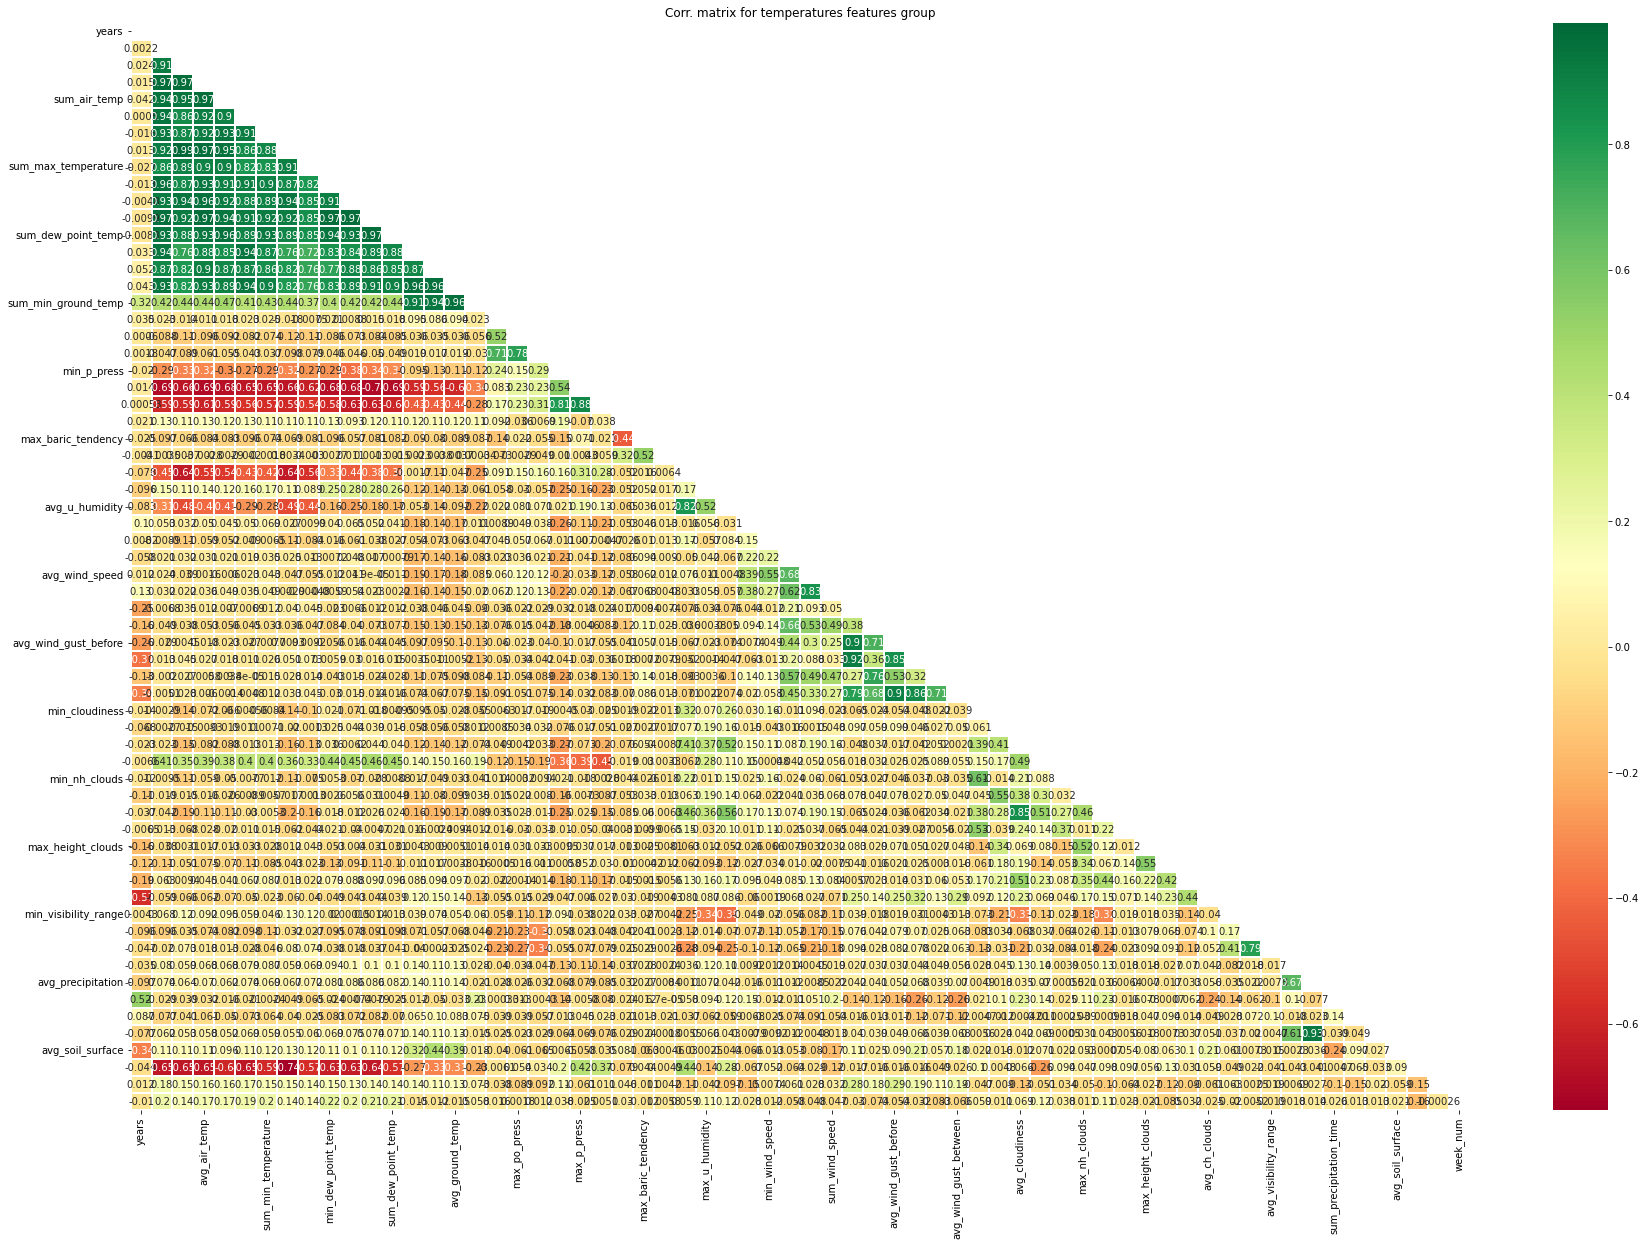

In [8]:
# Визуализация матрицы корреляций с помощью heatmap
mask = np.zeros_like(corr_matrix, dtype=np.bool) # скрываем дублирующие и единичные значения матрицы
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlGn', linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(30,20)
plt.title("Corr. matrix for temperatures features group")
plt.show();

In [9]:
# Информация о признаках в матрице кореляций
corr_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, years to week_num
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   years                      64 non-null     float64
 1   min_air_temp               64 non-null     float64
 2   max_air_temp               64 non-null     float64
 3   avg_air_temp               64 non-null     float64
 4   sum_air_temp               64 non-null     float64
 5   min_temp                   64 non-null     float64
 6   sum_min_temperature        64 non-null     float64
 7   max_temp                   64 non-null     float64
 8   sum_max_temperature        64 non-null     float64
 9   min_dew_point_temp         64 non-null     float64
 10  max_dew_point_temp         64 non-null     float64
 11  avg_dew_point_temp         64 non-null     float64
 12  sum_dew_point_temp         64 non-null     float64
 13  min_ground_temp            64 non-null     floa

C:\Users\uovorop\AppData\Local\Temp\ipykernel_4196\768854141.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix[1:17][corr_matrix.columns[1:17]], dtype=np.bool) # скрываем дублирующие и единичные значения матрицы


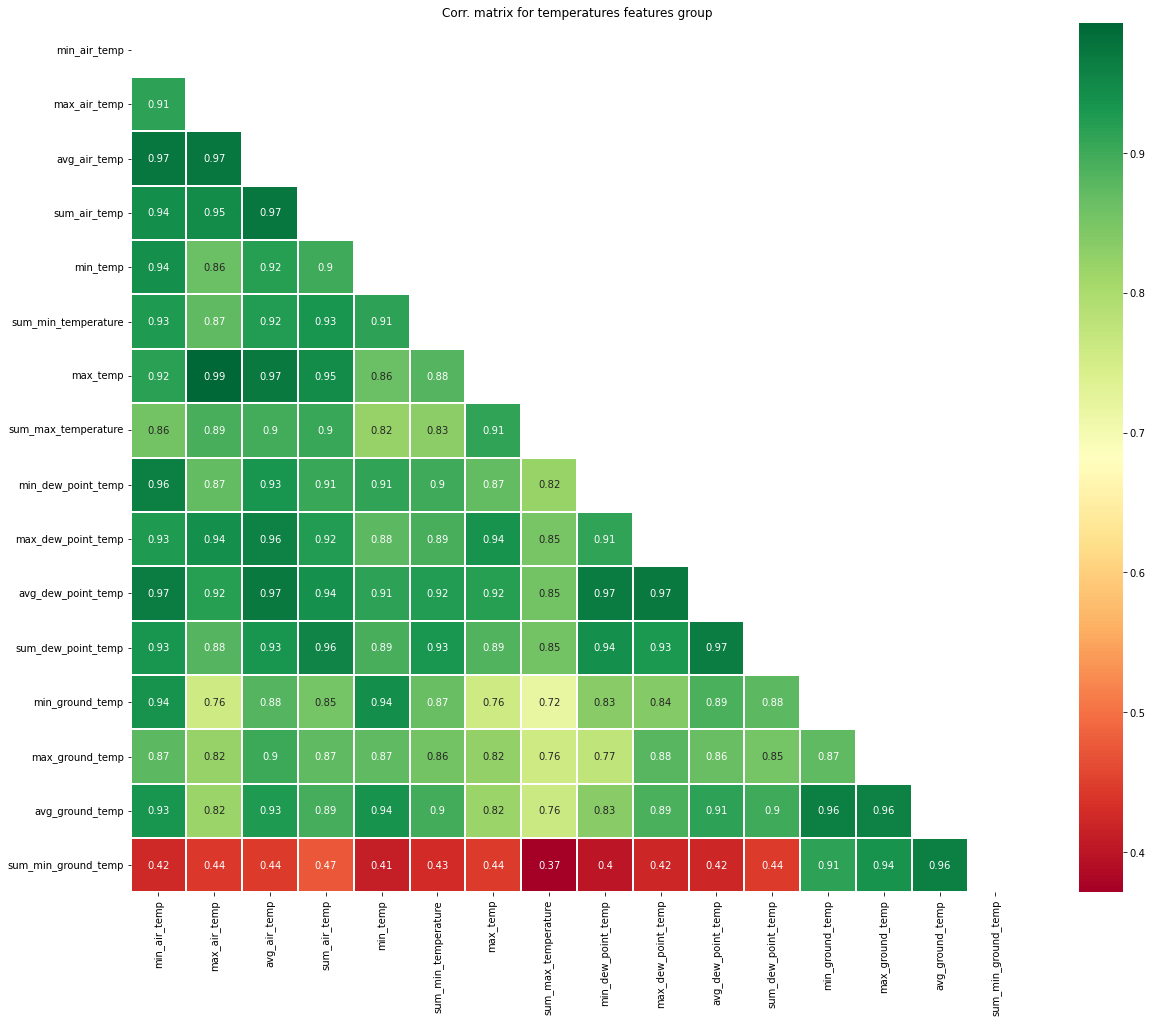

In [10]:
# Визуализация матрицы корреляций для группы признаков связанных с температурой воздуха
corr_matrix = weather.corr()
mask = np.zeros_like(corr_matrix[1:17][corr_matrix.columns[1:17]], dtype=np.bool) # скрываем дублирующие и единичные значения матрицы
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix[1:17][corr_matrix.columns[1:17]], mask=mask, annot=True, cmap='RdYlGn', 
            linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.title("Corr. matrix for temperatures features group")
plt.show();

C:\Users\uovorop\AppData\Local\Temp\ipykernel_4196\1129328185.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix[17:26][corr_matrix.columns[17:26]], dtype=np.bool) # скрываем дублирующие и единичные значения матрицы


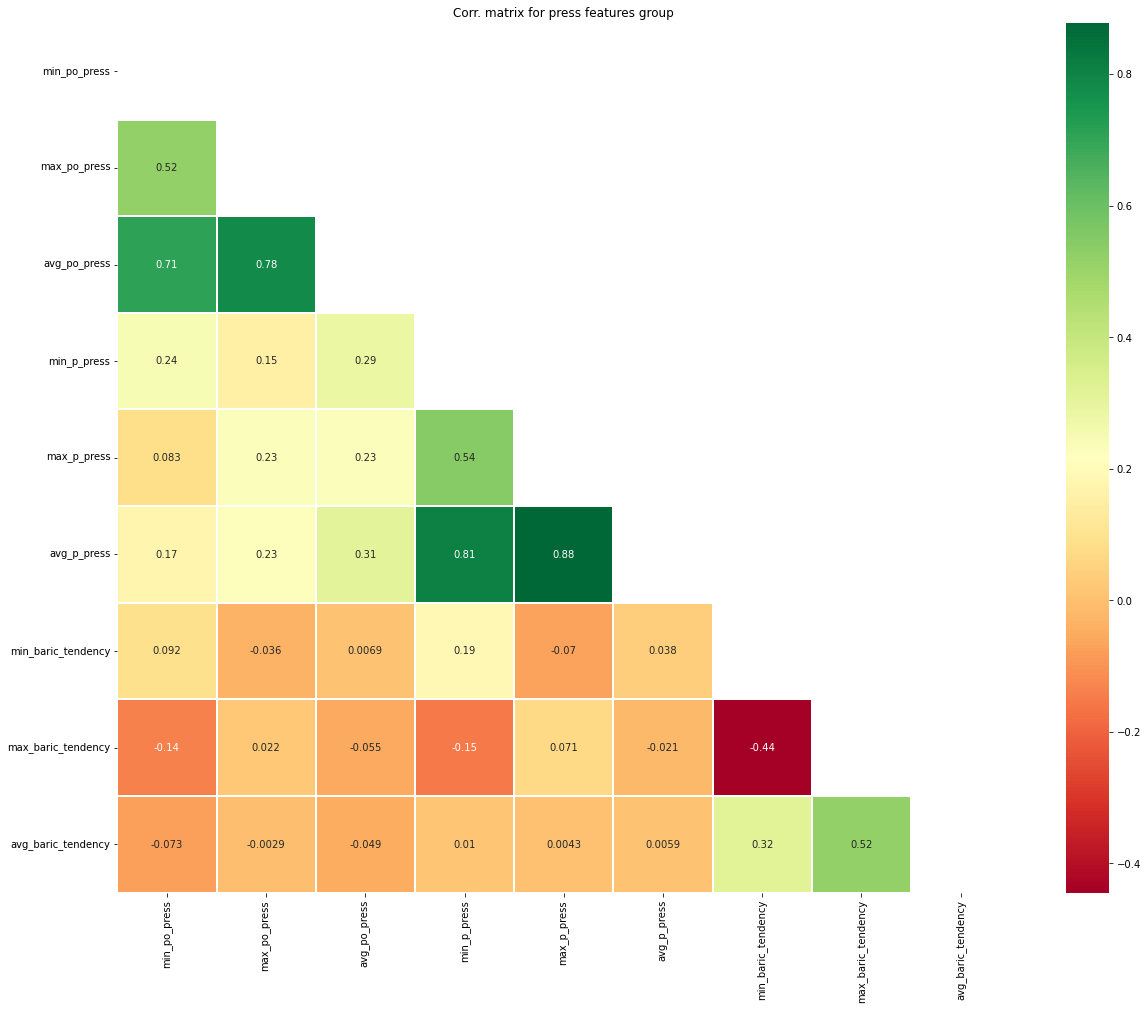

In [11]:
# Визуализация матрицы корреляций для группы признаков связанных с атмосферным давлением
corr_matrix = weather.corr()
mask = np.zeros_like(corr_matrix[17:26][corr_matrix.columns[17:26]], dtype=np.bool) # скрываем дублирующие и единичные значения матрицы
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix[17:26][corr_matrix.columns[17:26]], mask=mask, annot=True, cmap='RdYlGn', linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.title("Corr. matrix for press features group")
plt.show();

C:\Users\uovorop\AppData\Local\Temp\ipykernel_4196\2506399702.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix[17:26][corr_matrix.columns[1:17]], dtype=np.bool) # скрываем дублирующие и единичные значения матрицы


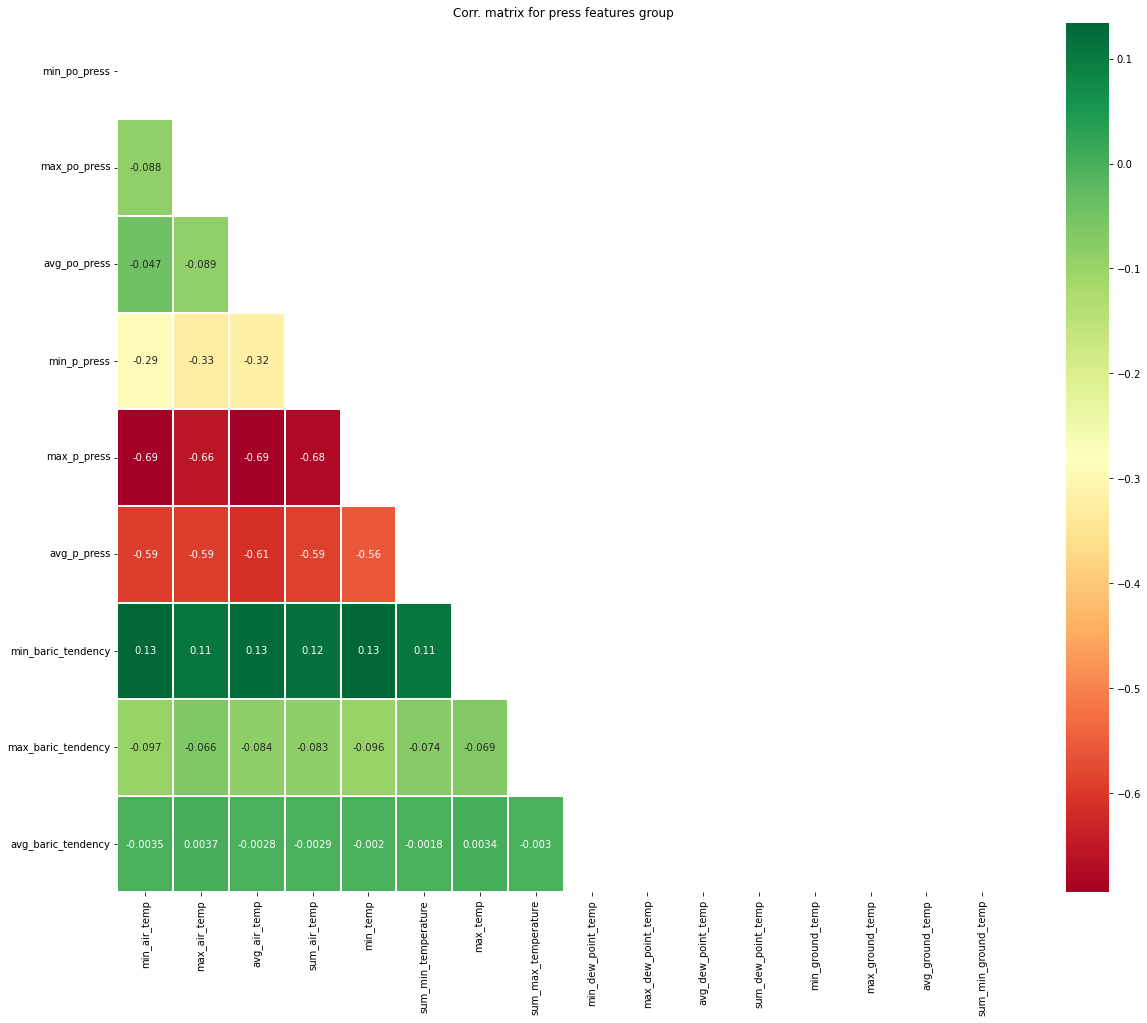

In [12]:
# Визуализация матрицы корреляций между группой признаков связанных с температурой и атм. давлением
corr_matrix = weather.corr()
mask = np.zeros_like(corr_matrix[17:26][corr_matrix.columns[1:17]], dtype=np.bool) # скрываем дублирующие и единичные значения матрицы
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix[17:26][corr_matrix.columns[1:17]], mask=mask, annot=True, cmap='RdYlGn', 
            linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.title("Corr. matrix for press features group")
plt.show();

**Комментарий:**<br>
1. Значения имеющие одинаковые базовые переменные для расчета (например, такие как: температура, атмосферное давление, облачность и т.д.) имеют очень высокую степень корреляции.
2. Отмечается обратная корреляция между переменными группы атмосферного давления и температуры воздуха.
3. В целом зависимость переменных между собой невысокая.
4. Так как для постороения предиктивной модели будет строится на моделях градиентного бустинга, то некоторые переменные имеющие высокую корреляцию было решено оставить, например, пороговые значения min, max. В соответсвии с гипотезой предполагается, что они могут стать важными признаками при построении прогноза урожайности. 
5. Другие переменные, которые имеют аналоги, высокую корреляцию и много пропущенных значений (такие как min_temp, max_temp) будут удалены.

### Формы распределения значений в переменных

<AxesSubplot:xlabel='sum_max_temperature', ylabel='Percent'>

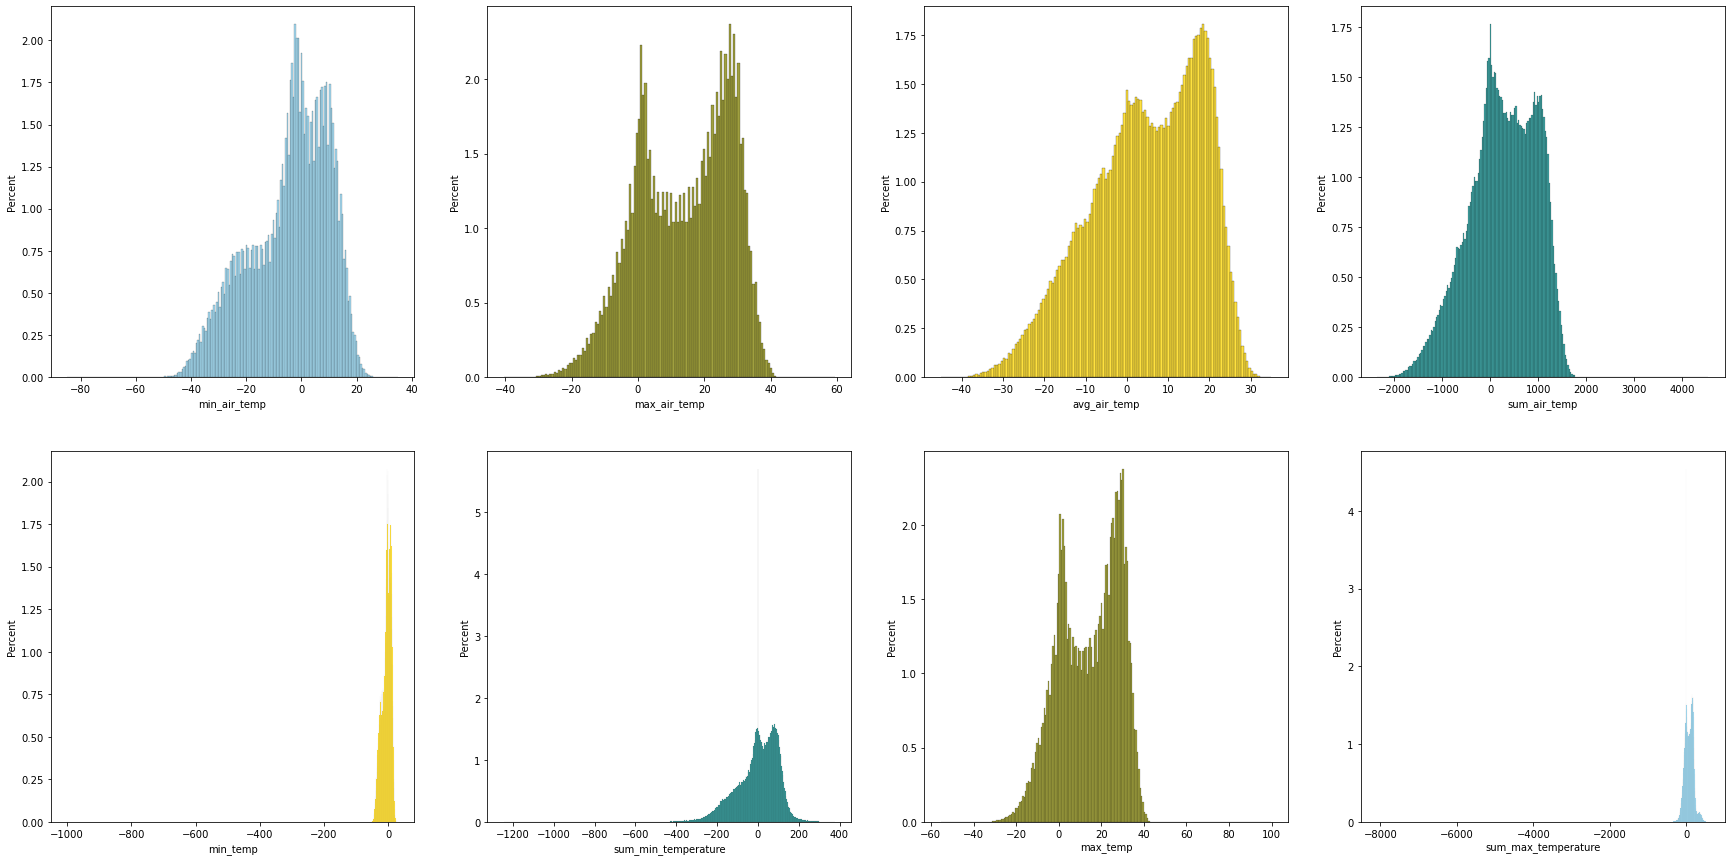

In [13]:
# Визуализация переменных группы температура воздуха
fig, axs = plt.subplots(2, 4, figsize=(30, 15))
feat_names = list(weather.columns[2:10])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0,0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[0,1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[0,2])
sns.histplot(data[feat_names[3]], stat='percent', color="teal", ax=axs[0,3])

sns.histplot(data[feat_names[4]], stat='percent', color="gold", ax=axs[1,0])
sns.histplot(data[feat_names[5]], stat='percent', color="teal", ax=axs[1,1])
sns.histplot(data[feat_names[6]], stat='percent', color="olive", ax=axs[1,2])
sns.histplot(data[feat_names[7]], stat='percent', color="skyblue", ax=axs[1,3])

<AxesSubplot:xlabel='sum_dew_point_temp', ylabel='Percent'>

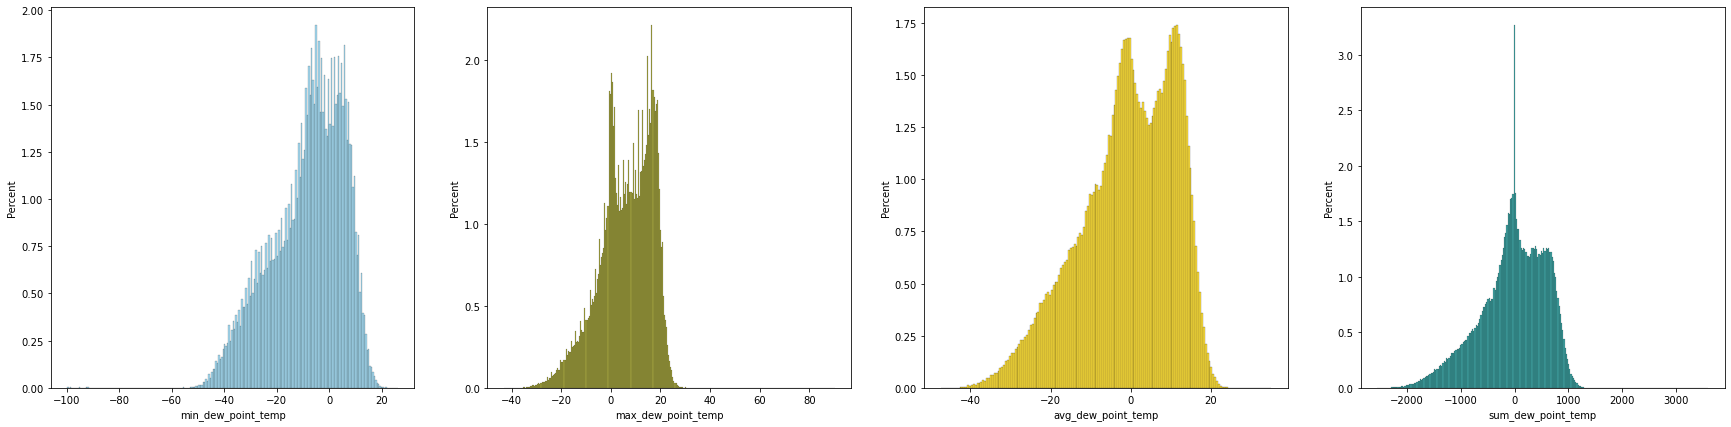

In [14]:
# Визуализация переменных группы температура точки росы
fig, axs = plt.subplots(1, 4, figsize=(30, 7))
feat_names = list(weather.columns[10:14])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[2])
sns.histplot(data[feat_names[3]], stat='percent', color="teal", ax=axs[3])

<AxesSubplot:xlabel='sum_min_ground_temp', ylabel='Percent'>

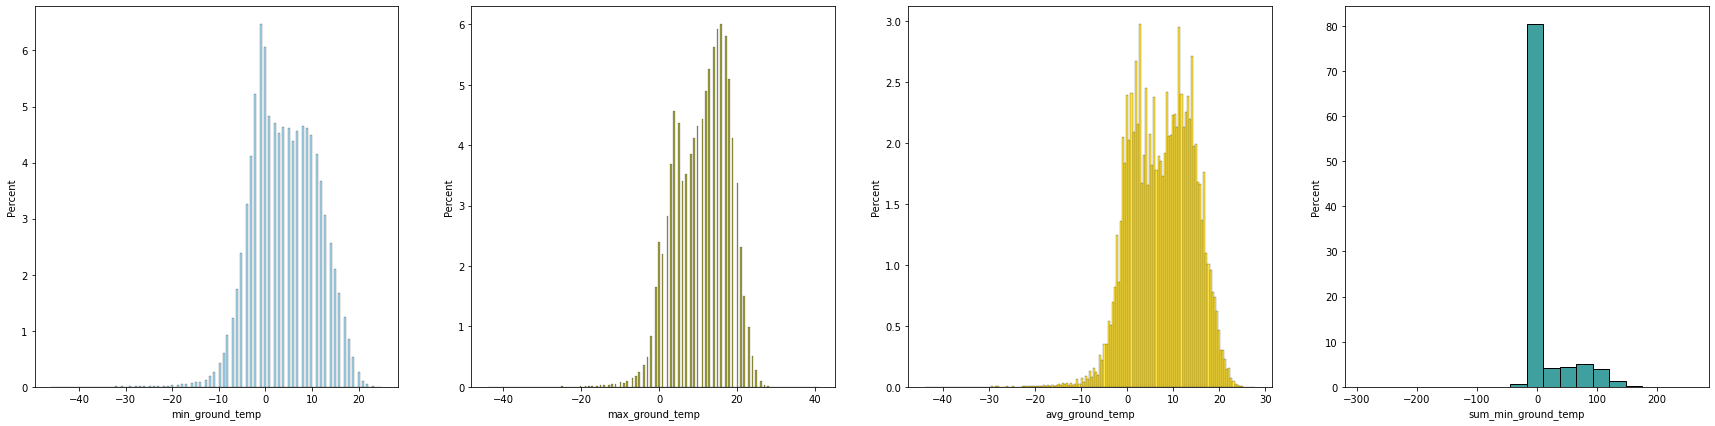

In [15]:
# Визуализация переменных группы температура поверхности почвы
fig, axs = plt.subplots(1, 4, figsize=(30, 7))
feat_names = list(weather.columns[14:18])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[2])
sns.histplot(data[feat_names[3]], stat='percent', color="teal", ax=axs[3])

<AxesSubplot:xlabel='avg_p_press', ylabel='Percent'>

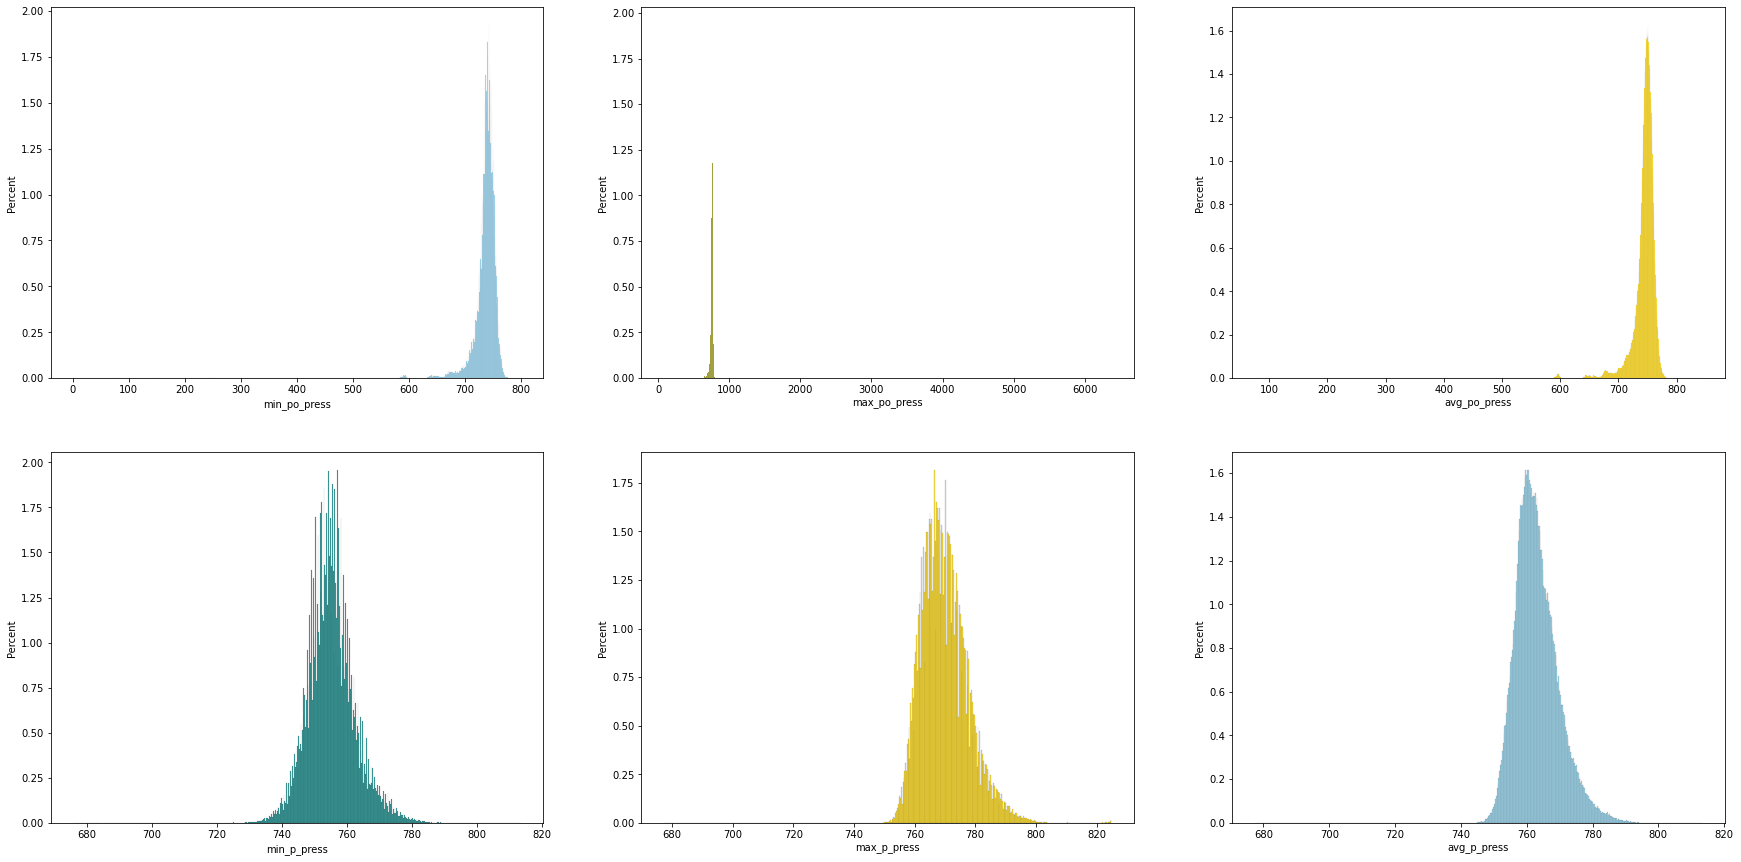

In [16]:
# Визуализация переменных группы атмосферное давление
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
feat_names = list(weather.columns[18:24])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0,0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[0,1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[0,2])

sns.histplot(data[feat_names[3]], stat='percent', color="teal", ax=axs[1,0])
sns.histplot(data[feat_names[4]], stat='percent', color="gold", ax=axs[1,1])
sns.histplot(data[feat_names[5]], stat='percent', color="skyblue", ax=axs[1,2])

<AxesSubplot:xlabel='avg_baric_tendency', ylabel='Percent'>

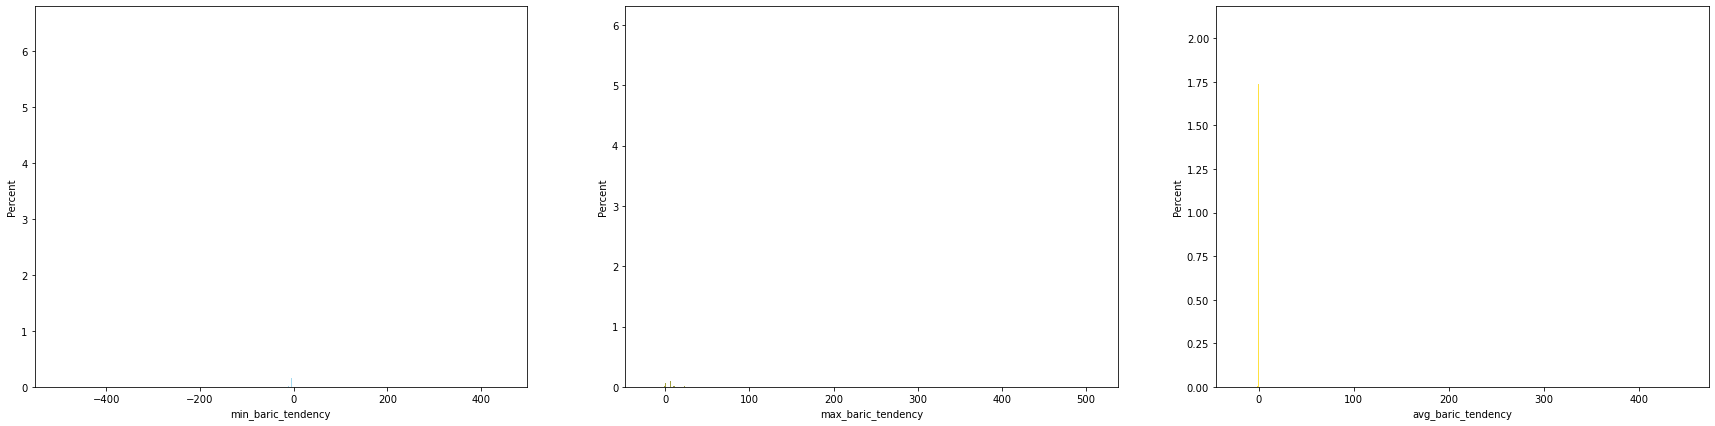

In [17]:
# Визуализация переменных группы барическая тенденция (изм. атмосферного давления)
fig, axs = plt.subplots(1, 3, figsize=(30, 7))
feat_names = list(weather.columns[24:27])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[2])

<AxesSubplot:xlabel='avg_u_humidity', ylabel='Percent'>

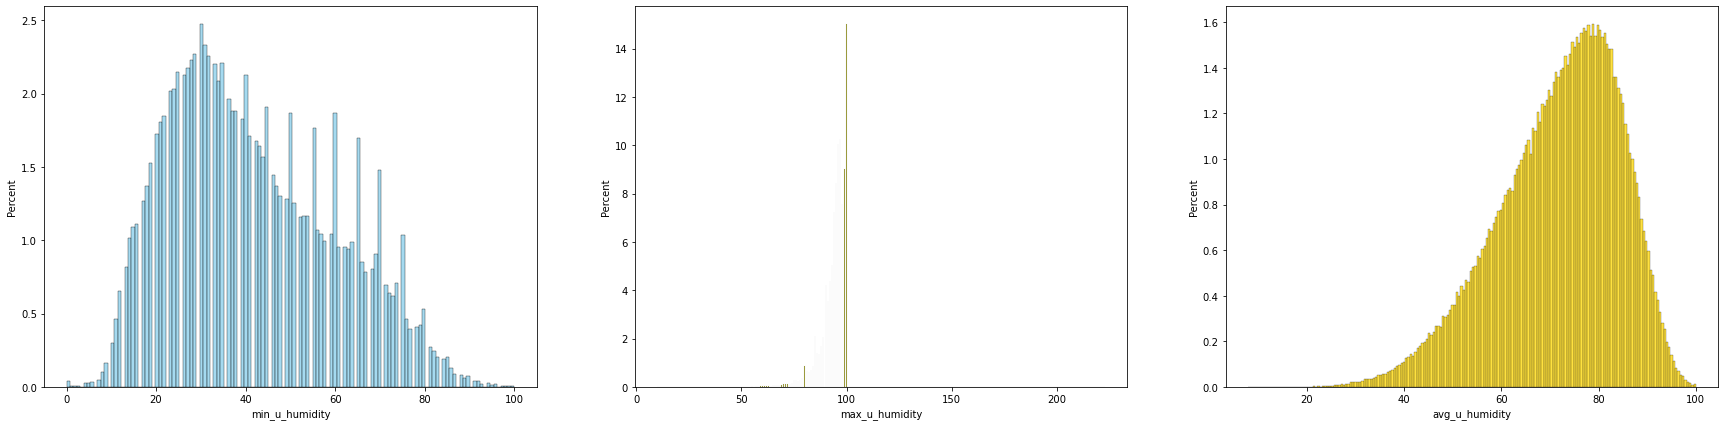

In [18]:
# Визуализация переменных группы влажность воздуха
fig, axs = plt.subplots(1, 3, figsize=(30, 7))
feat_names = list(weather.columns[27:30])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[2])

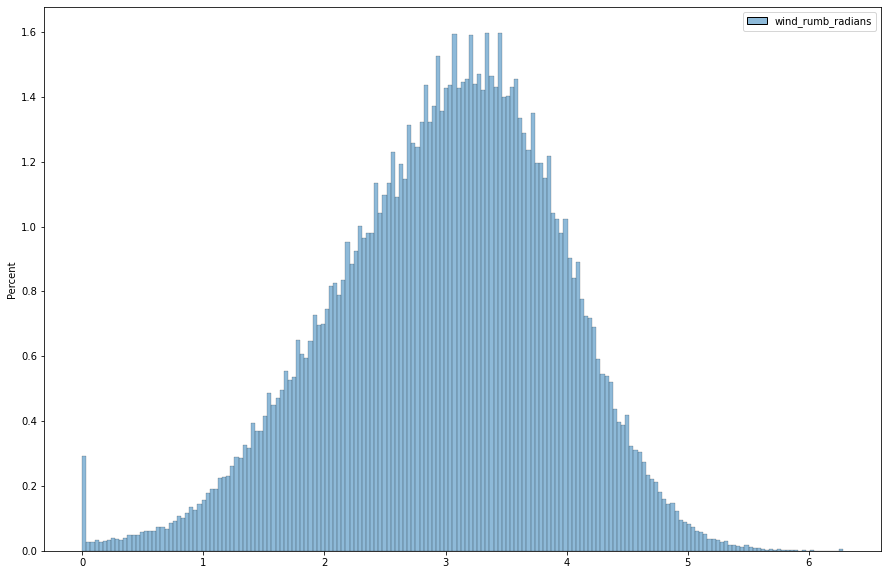

In [19]:
# Визуализация переменной направление ветра (румб)
data = weather[['wind_rumb_radians']]
wr = sns.histplot(data, stat='percent', color="olive")
wr.figure.set_size_inches(15,10)

<AxesSubplot:xlabel='avg_wind_gust_between', ylabel='Percent'>

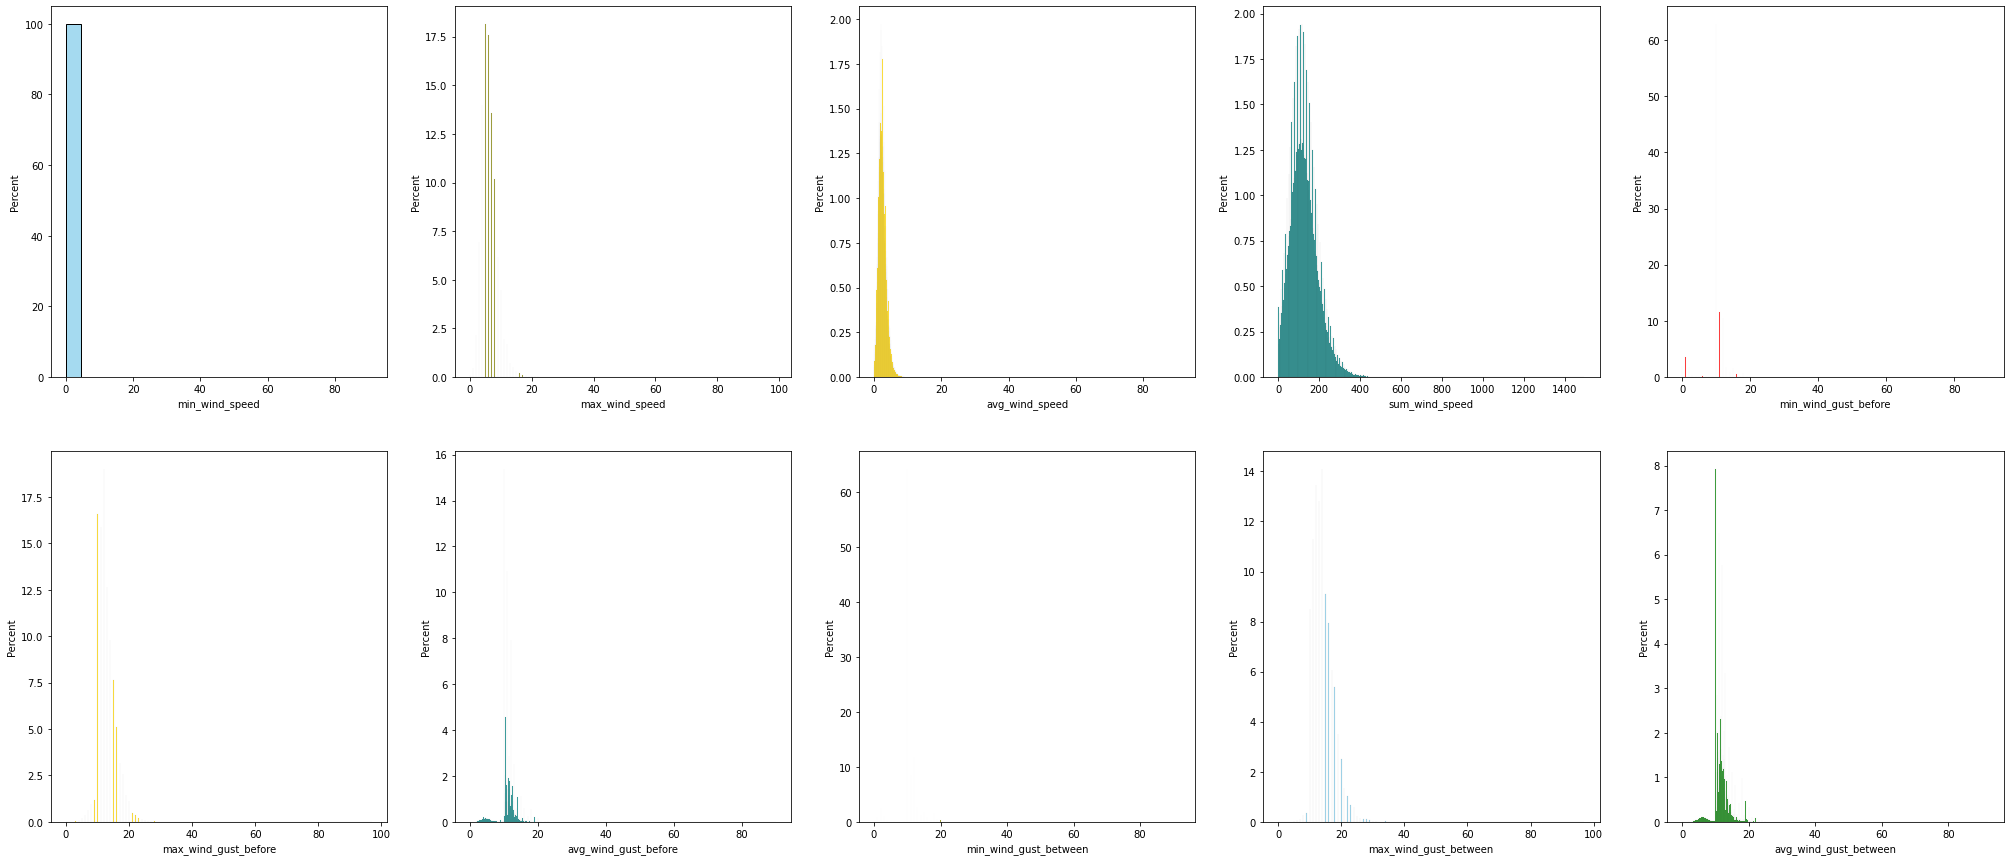

In [20]:
# Визуализация переменных группы скорость ветра
fig, axs = plt.subplots(2, 5, figsize=(35, 15))
feat_names = list(weather.columns[31:41])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0,0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[0,1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[0,2])
sns.histplot(data[feat_names[3]], stat='percent', color="teal", ax=axs[0,3])
sns.histplot(data[feat_names[4]], stat='percent', color="red", ax=axs[0,4])

sns.histplot(data[feat_names[5]], stat='percent', color="gold", ax=axs[1,0])
sns.histplot(data[feat_names[6]], stat='percent', color="teal", ax=axs[1,1])
sns.histplot(data[feat_names[7]], stat='percent', color="olive", ax=axs[1,2])
sns.histplot(data[feat_names[8]], stat='percent', color="skyblue", ax=axs[1,3])
sns.histplot(data[feat_names[9]], stat='percent', color="green", ax=axs[1,4])

<AxesSubplot:xlabel='avg_ch_clouds', ylabel='Percent'>

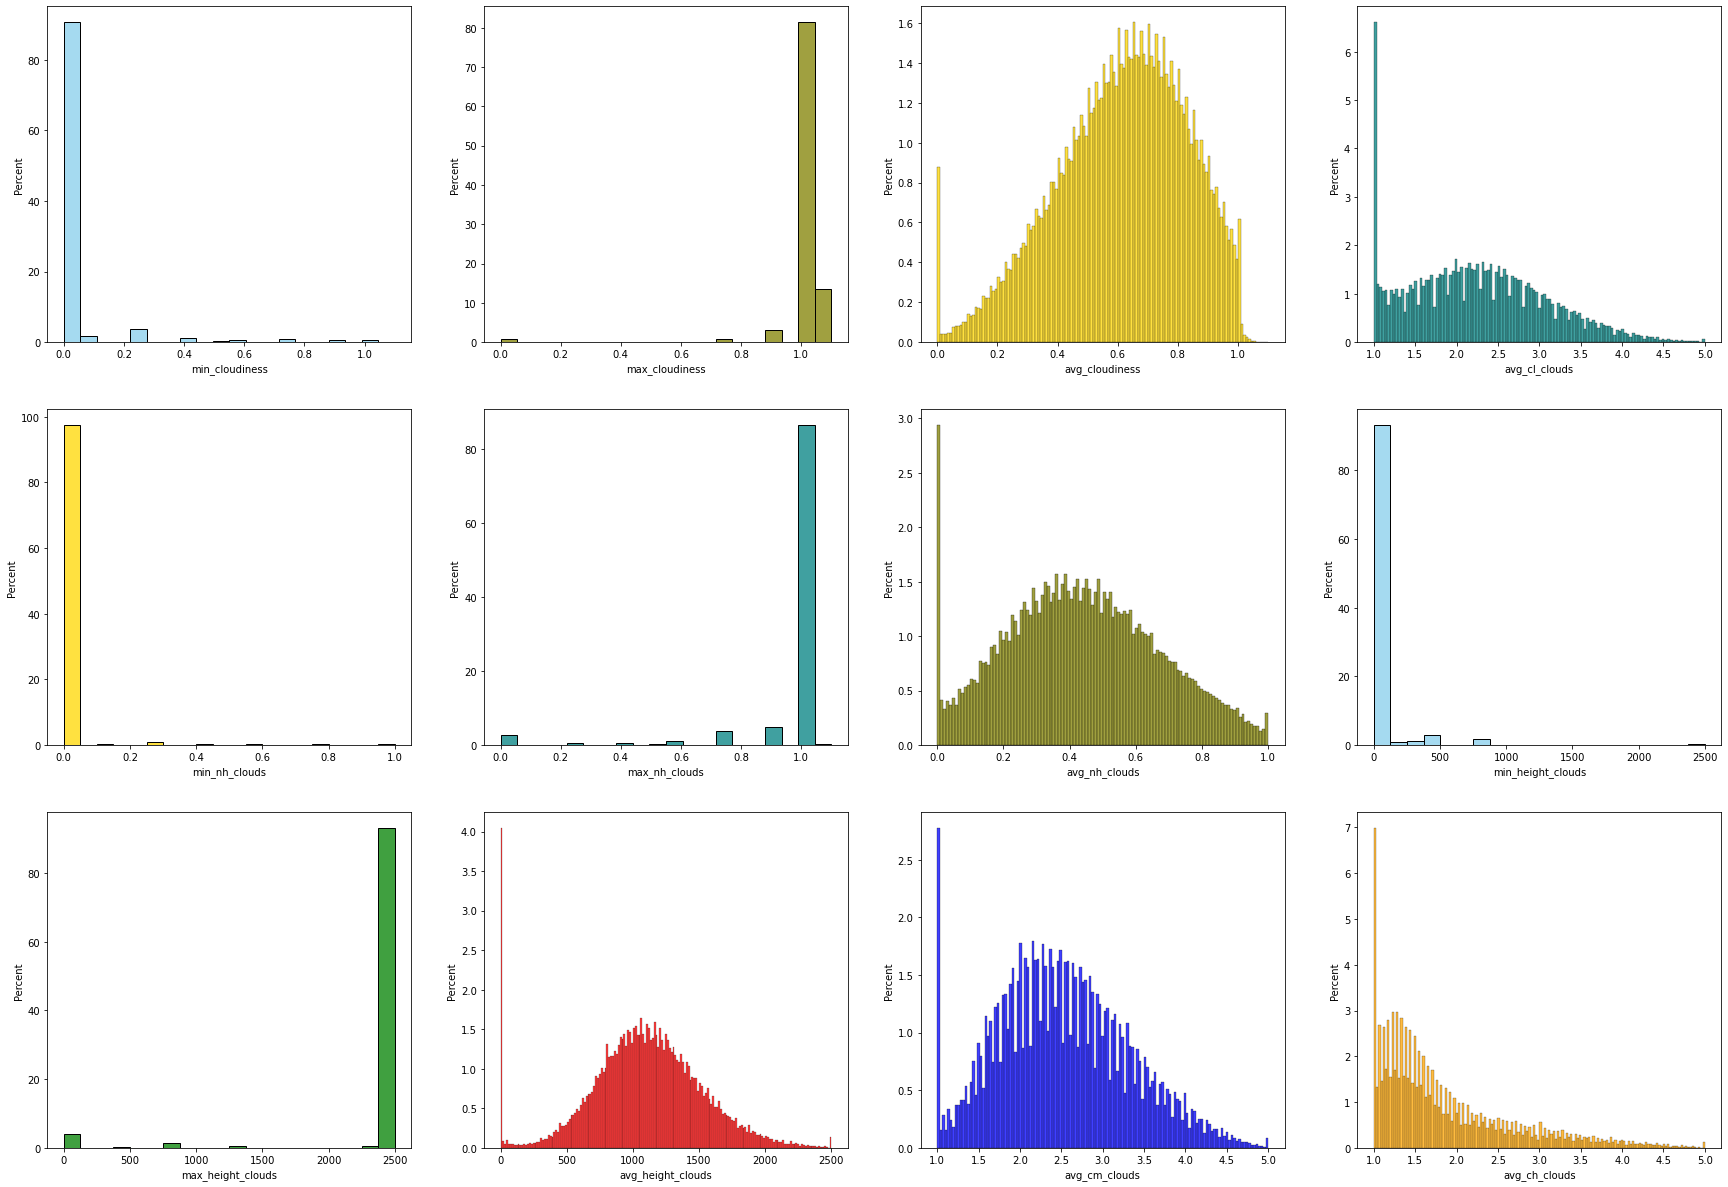

In [21]:
# Визуализация переменных группы облачность
fig, axs = plt.subplots(3, 4, figsize=(30, 21))
feat_names = list(weather.columns[41:53])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0,0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[0,1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[0,2])
sns.histplot(data[feat_names[3]], stat='percent', color="teal", ax=axs[0,3])

sns.histplot(data[feat_names[4]], stat='percent', color="gold", ax=axs[1,0])
sns.histplot(data[feat_names[5]], stat='percent', color="teal", ax=axs[1,1])
sns.histplot(data[feat_names[6]], stat='percent', color="olive", ax=axs[1,2])
sns.histplot(data[feat_names[7]], stat='percent', color="skyblue", ax=axs[1,3])

sns.histplot(data[feat_names[8]], stat='percent', color="green", ax=axs[2,0])
sns.histplot(data[feat_names[9]], stat='percent', color="red", ax=axs[2,1])
sns.histplot(data[feat_names[10]], stat='percent', color="blue", ax=axs[2,2])
sns.histplot(data[feat_names[11]], stat='percent', color="orange", ax=axs[2,3])


<AxesSubplot:xlabel='avg_visibility_range', ylabel='Percent'>

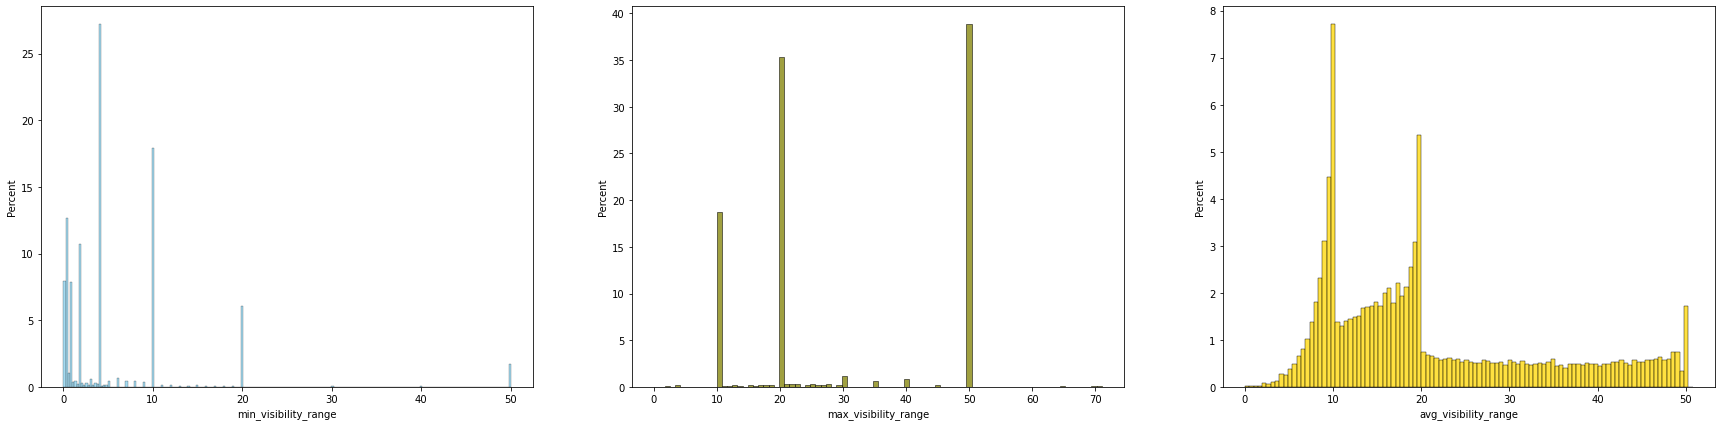

In [22]:
# Визуализация переменных группы горизонтальная дальность видимости
fig, axs = plt.subplots(1, 3, figsize=(30, 7))
feat_names = list(weather.columns[53:56])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[2])

<AxesSubplot:xlabel='precipitation_speed', ylabel='Percent'>

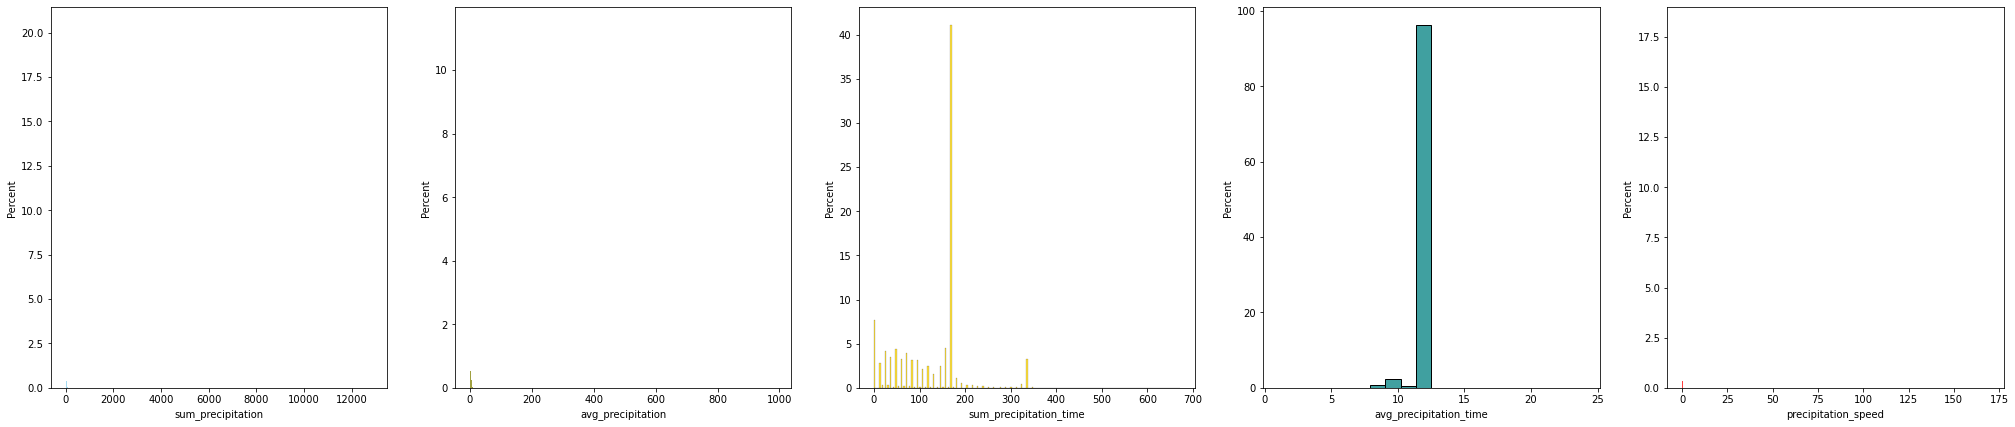

In [23]:
# Визуализация переменных группы количество выпавших осадков
fig, axs = plt.subplots(1, 5, figsize=(35, 7))
feat_names = list(weather.columns[56:61])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="skyblue", ax=axs[0])
sns.histplot(data[feat_names[1]], stat='percent', color="olive", ax=axs[1])
sns.histplot(data[feat_names[2]], stat='percent', color="gold", ax=axs[2])
sns.histplot(data[feat_names[3]], stat='percent', color="teal", ax=axs[3])
sns.histplot(data[feat_names[4]], stat='percent', color="red", ax=axs[4])

<AxesSubplot:xlabel='avg_soil_surface_withsnow', ylabel='Percent'>

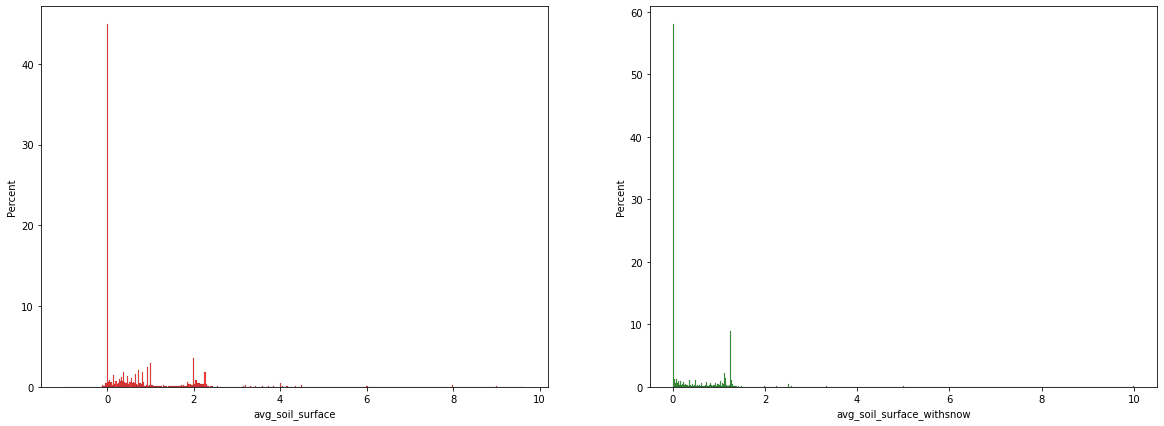

In [24]:
# Визуализация переменных группы состояние поверхности почвы
fig, axs = plt.subplots(1, 2, figsize=(20, 7))
feat_names = list(weather.columns[61:63])
data = weather[feat_names]
sns.histplot(data[feat_names[0]], stat='percent', color="red", ax=axs[0])
sns.histplot(data[feat_names[1]], stat='percent', color="green", ax=axs[1])

In [25]:
# Удаление промежуточных данных (для очистки оперативной памяти)
del weather

**Краткие комментарии и выводы:**<br>
1. Признки в группе показателей температуры (темп. воздуха, точки росы, поверхности почвы) имеют бимодальное распределение - это связано с сезонностью температур (зимний и летний сезоны имеют свои значения моды);<br>
2. Средние значения переменной атмосферного давление имеют распределение близкое к нормальному распределению, с низким значением σ и наличием выбросов;<br>
3. Значения из из группы признаков барической тенденции (изменение атмосферного давления), не имеют какой-либо ярко выраженной формы распределения значений;<br>
4. Значения переменной влажность воздуха расположены в диапазоне от 0 - до 100%, нормальные значения расположенв в диапазоне 60-80%, отклонения от нормы больше являются аномалиями;<br>
5. Направление ветра (значение переменной находится в диапазоне от 0 - до 2π). Среднняя роза ветров имеет преобладание в сторону юго-юго-запада (180°-225°);<br>
6. Значения переменных из группы скорость ветра стремятся к своему среднему значению от 0 - до 15 м/с (имеют низкое значение σ). Слишком большие значения это аномалия или опасные природные явления;<br>
7. Переменные из группы обласчности имеют три типа показателей - облачность (%), высота облаков (м) и типы обласков (в баллах 0-5), все показатели имеют дискретные значения (начинаются с 0). Средние значения всех показателей стремятся в нормальному распределению, значения min и max к своим экстремумам;<br>
8. Переменная горизонтальная видимость не имеет какого-либо ярко выраженного типа распределения значений;<br>
9. Признак количество выпавших осадков, также не имеею четкой формы распределения<br>
10. Значения признаков поверхности почвы имеют дискретные значения (от -2 до 10 и от 0 до 10). Четко выраженная форма распределения значений отсутствует. Большая часть значений расположена от 0 до 4 и от 0 до 3.

## 2. Исследование набора данных с целевой переменной

In [26]:
# Чтение данных с целевой переменной
target = pd.read_csv('INPUT/target.csv.zip', compression='zip', header=0, sep=';', decimal=',',
                     dtype={'digit_id': 'object'}, quotechar='"')

In [27]:
# Предварительный просмотр данных
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20020 entries, 0 to 20019
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   letter_id      20020 non-null  object 
 1   digit_id       20020 non-null  object 
 2   agriculture    20020 non-null  object 
 3   federal_distr  20020 non-null  object 
 4   region         20020 non-null  object 
 5   municipal      20020 non-null  object 
 6   name_municip   20020 non-null  object 
 7   category       20020 non-null  object 
 8   year           20020 non-null  int64  
 9   yield          20020 non-null  float64
 10  round_yield    20020 non-null  int64  
 11  check          20020 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


Комментарий:

1. Набор данных состоит из 20020 строк и 12 столбцов;
2. Набор содержит три типа данных - object (8 столбцов), float (1 столбец), int (3 столбца). Данные загружены корректно, все типы соответствуют исходному набору из DB "weather";
3. В загруженном наборе отсутствуют столбцы с пропущенными значениями.

In [28]:
# Основные статистики для целевой переменной (урожайность подсолнечника)
target.describe()['yield']

count    20020.000000
mean        13.909091
std          7.371703
min          1.300000
25%          8.130000
50%         12.500000
75%         19.000000
max         47.900000
Name: yield, dtype: float64

In [29]:
# Мода
target['yield'].mode().T

0    10.0
Name: yield, dtype: float64

**Комментарий:** средннее, медианное и модальное значения переменной отличаются друг от друга. Необходимо более детально изучить набор данных с целевой переменной. 

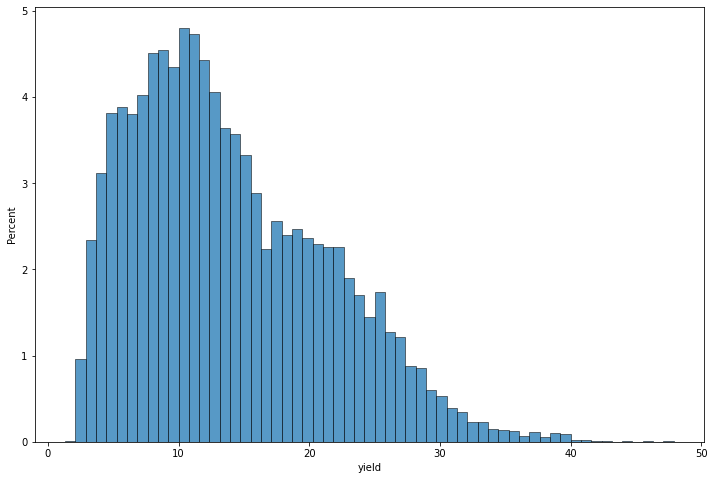

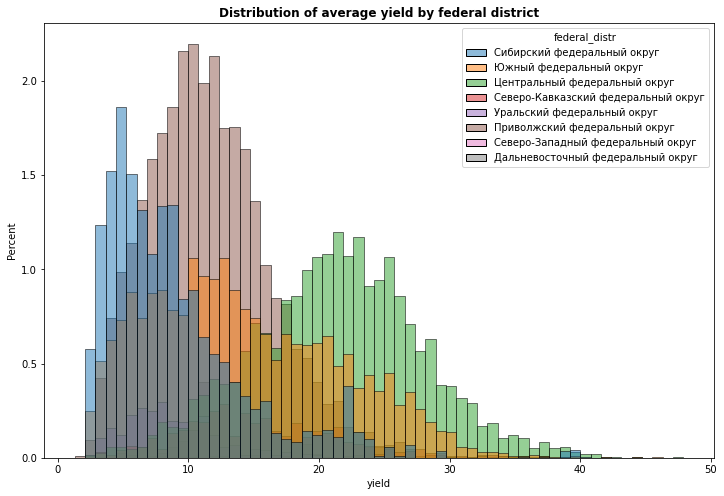

In [30]:
# Визуализация целевой переменной урожайность
targ = sns.histplot(data=target, x='yield', stat='percent')
targ.figure.set_size_inches(12,8)
plt.show()

# Визуализация распределения целевой переменной по федеральным округам (ФО)
data = target[['federal_distr', 'yield']]
pic_yield = sns.histplot(data=data, x='yield', hue='federal_distr', stat='percent')
pic_yield.figure.set_size_inches(12,8)
plt.title('Distribution of average yield by federal district', fontweight='bold') # заголовок графика
plt.show()

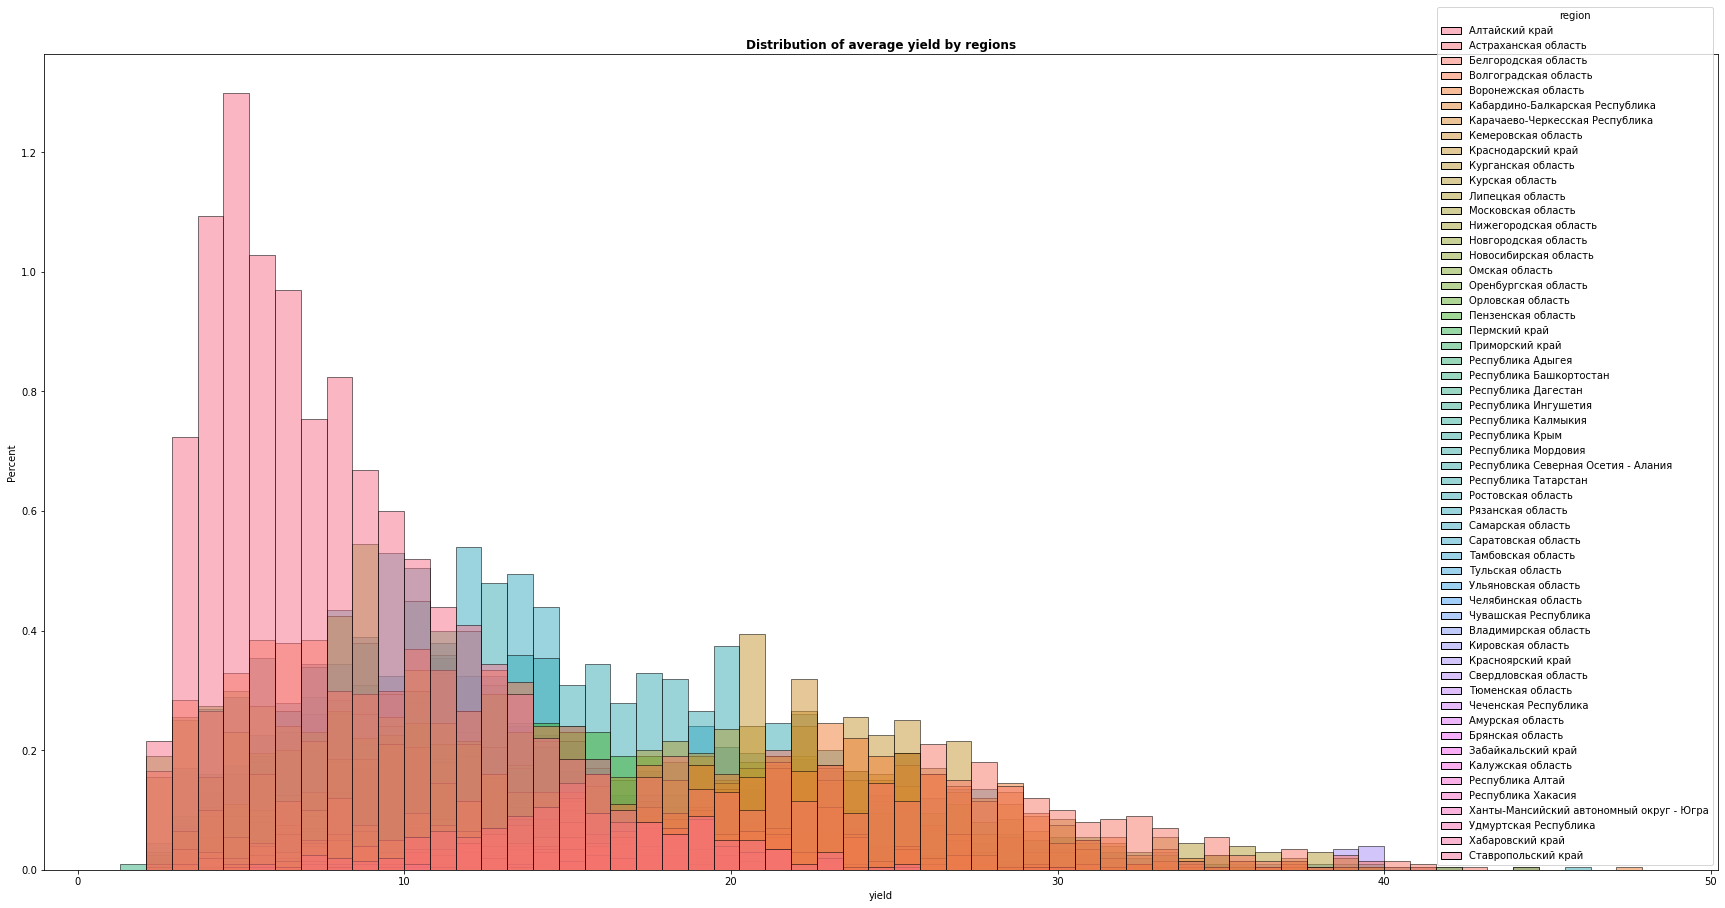

In [31]:
# Визуализация распределения целевой переменной по федеральным округам (ФО)
data = target[['region', 'yield']]
reg_yield = sns.histplot(data=data, x='yield', hue='region', stat='percent')
reg_yield.figure.set_size_inches(30,15)
plt.title('Distribution of average yield by regions', fontweight='bold') # заголовок графика
plt.show();

**Комментарий:**<br>
1. Форма распределения значений целевой переменной стремится к бимодальному, хотя при этом имеет ярко выраженную вершину (моду) со значением 10.0.<br>
2. Визуализация распределения целевой переменной по федеральным округам показывает, что модальные значения по федеральным округам имеют существенные отличия. Так, например, значения моды Сибирского ФО, Приволжского ФО и Центрального ФО имеет заметные визуальные отличия.<br>
3. Еще более сильные отличия модальных значений и форм распределения данных наблюдаются в разрезе по регионам.

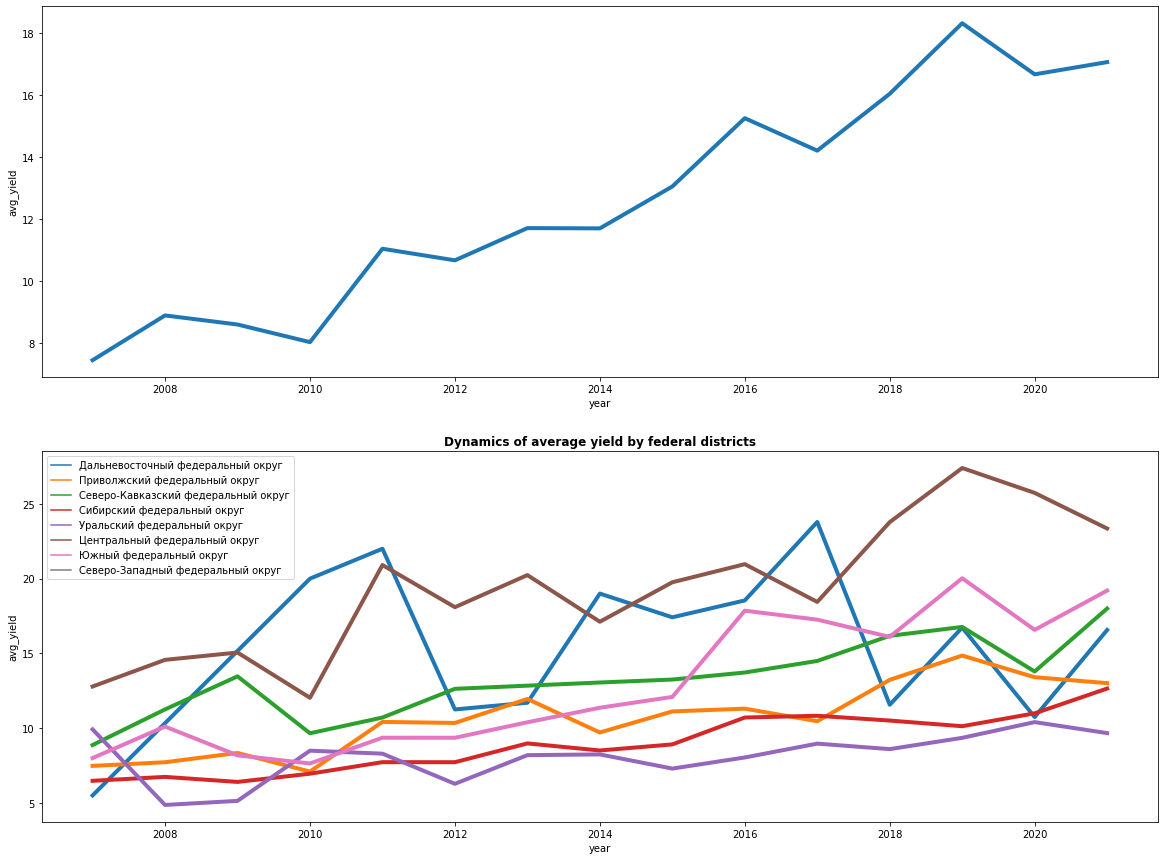

In [32]:
# Динамика целевой переменной по годам (+ динамика в разрезе по ФО)
# создание набора данных для визуализации
trend = target.groupby(['year']).agg(avg_yield=('yield', np.mean))
trend_fed = target.groupby(['year', 'federal_distr']).agg(avg_yield=('yield', np.mean))

# динамика средней урожайности
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
sns.lineplot(data=trend, x="year", y="avg_yield", linewidth = 4, ax=axs[0])
plt.title('Dynamics of average yield', fontweight='bold')

# динамика средней урожайности по ФО
sns.lineplot(data=trend_fed, x="year", y="avg_yield", linewidth = 4, hue="federal_distr", ax=axs[1])
plt.title('Dynamics of average yield by federal districts', fontweight='bold')
plt.legend(loc='upper left')
plt.show();

**Комментарий:**<br>
1. График динамики средней урожайности показывает наличие восходящего тренда. Аналогичная ситуация наблюдается с графиками урожайности в разрезе по ФО.
2. Наличие трендовой составляющей в целевой переменной может стать негативным фактором для поиска зависисмостей между величиной урожайности и данными о погоде.

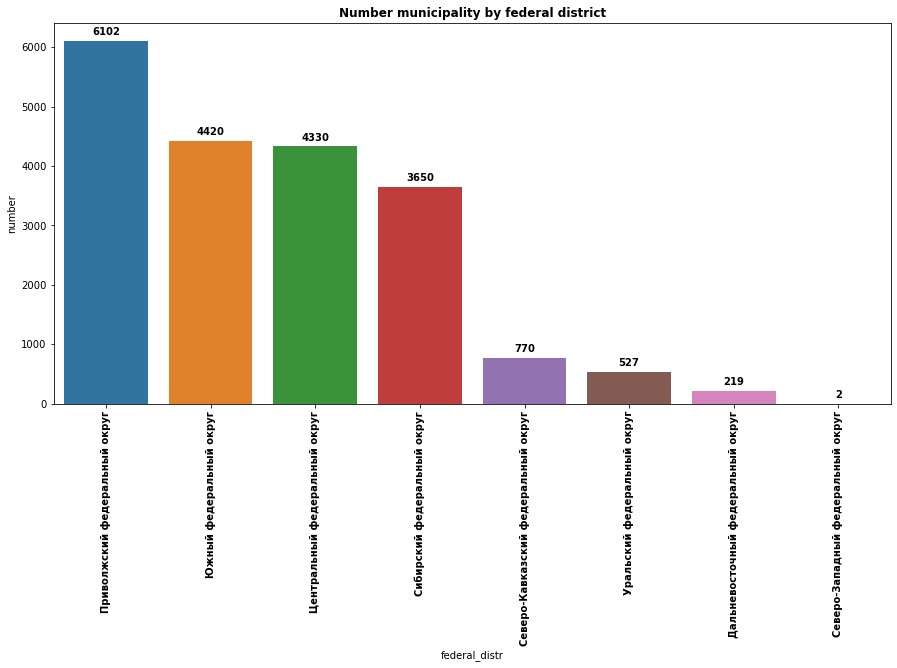

In [33]:
# Количество муниципальных районов по ФО
df = target[['federal_distr']].value_counts().reset_index()
df.columns = ['federal_distr','number']

fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=df, y='number', x='federal_distr')
plt.title('Number municipality by federal district', fontweight='bold') # заголовок графика
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points',
                fontweight='bold')
plt.xticks(rotation=90, fontweight='bold')
plt.show();

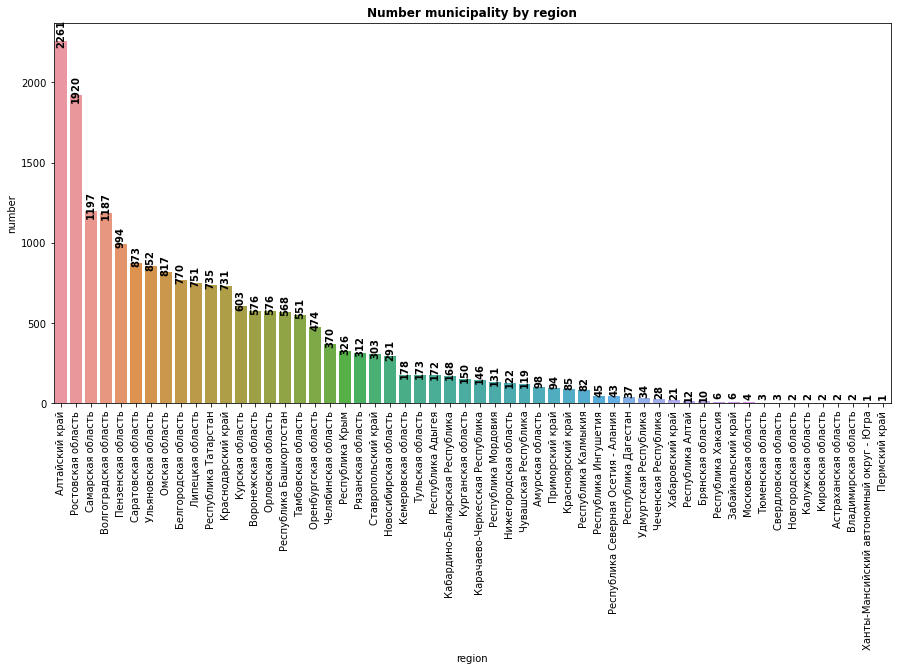

In [34]:
# Распределение муниципальных районов по регионам
df = target[['region']].value_counts().reset_index()
df.columns = ['region','number']

fig, ax = plt.subplots(figsize=(15,7))
sns.barplot(data=df, y='number', x='region')
plt.title('Number municipality by region', fontweight='bold') # заголовок графика
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 7), textcoords = 'offset points', rotation=90,
                fontweight='bold')
plt.xticks(rotation=90)
plt.show();

**Комментарий:**<br>
1. Наибольшее количество муниципальных районов отмечено в Приволжском округе (6102 объектов), наименьшее в Северо-Западном (2 объекта);
2. Самое большое количество объектов находится в Алтайском крае (2261) и Ростовской области (1920), в 12 регионах количество объектов менее 10.

In [35]:
# Удаление промежуточных данных (для очистки оперативной памяти)
del target

**Краткие выводы:**<br>
1. Территориальное расположение муниципального района яляется является одним из важных признаков, которое определяет величину урожайности. Распределение значений целевой переменной имеет существенные различия по регионам. Данные признаки следует добавить в набор признаков для обучения ML-модели.<br>
2. Анализ динамики урожайности по годам выявил наличие тренда в целевой переменной. Наличие трендовой составляющей в таргете может стать негативным фактором для поиска зависисмостей между величиной урожайности и данными о погоде. Для более эффективного прогнозирования урожайности необходимо выявить и  удалить трендовую составляющую. Для цели выявления трендовой компонеты наиболее эффективно подойдет анализ сингулярного спектра (SSA).<br>
3. Для повышения эффективности прогнозирования урожайности подсолнечника можно попробовать обучение предиктивных моделей отдельно по каждому региону (используя набор данных по региону). Возможно, что таким образом модели смогут более эффективно выявить закономерности влияющие на величину урожайности. Таким образом, регионы в которых менее 33 объектов (не менее 30 для обучения и 10% на тест) необходимо исключить из процесса обучения.